In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten

In [2]:
img_width, img_height = 128, 128
batch_size = 32

In [3]:
def create_generator(df):


    datagen = ImageDataGenerator(rescale=1 / 255.0)
    generator = datagen.flow_from_dataframe(
        dataframe=df, x_col='path', y_col='label',
        target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
        shuffle=False,
    )

    return generator

In [4]:
def create_model(no_of_classes):
    model = Sequential()

    model.add(Conv2D(32, (5, 5), input_shape=(img_width, img_height, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))

    model.add(Dense(no_of_classes, activation='softmax'))

    model.summary()

    return model

In [5]:
def decode(value):
    class_indices = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10,
                     'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20,
                     'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}

    key_list = list(class_indices.keys())
    val_list = list(class_indices.values())

    # print key with val 100
    position = val_list.index(value)
    return key_list[position]

image size : (200, 200, 3)
train size : 62400
test size : 15600
Found 62400 validated image filenames belonging to 26 classes.
Found 15600 validated image filenames belonging to 26 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 activation (Activation)     (None, 124, 124, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 60, 60, 64)        0        

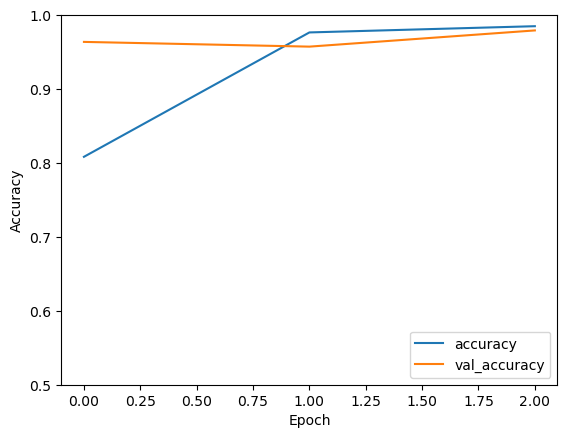

In [11]:
if __name__ == "__main__":
    train_folder = r'C:\Users\Win11\Desktop\asl_alphabet_train\asl_alphabet_train'
    all_data = []

    # GET ALL FILES IN FOLDER
    for folder in os.listdir(train_folder):
        label_folder = os.path.join(train_folder, folder)
        onlyfiles = [{'label': folder, 'path': os.path.join(label_folder, f)} for f in os.listdir(label_folder) if
                     os.path.isfile(os.path.join(label_folder, f))]
        all_data += onlyfiles

    data_df = pd.DataFrame(all_data)

    # images size : (200, 200, 3)
    rnd_img = mpimg.imread(data_df['path'].iloc[0])
    print(f'image size : {rnd_img.shape}')

    # splitting data
    train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42, stratify=data_df[['label']])
    print(f'train size : {len(train_df)}')
    print(f'test size : {len(test_df)}')


    no_of_classes = len(data_df['label'].unique())

    # TRAINING GENERATOR
    train_datagen = ImageDataGenerator(rescale=1 / 255.0)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df, x_col='path', y_col='label',
        target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
        shuffle=False,
    )

    # TESTING GENERATOR
    validation_datagen = ImageDataGenerator(rescale=1 / 255.0)
    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=test_df, x_col='path', y_col='label',
        target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
        shuffle=False
    )



    no_of_classes = len(data_df['label'].unique())

    model = create_model(no_of_classes)


    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    checkpoint_path = "training/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    #model.load_weights(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)


    history = model.fit(train_generator, epochs=3,
                        validation_data=validation_generator,
                        callbacks=[cp_callback])

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    test_loss, test_acc = model.evaluate(validation_generator)
    print('loss :', test_loss, 'acc :', test_acc)

    model.save('asl_model.h5')
    print("Model saved successfully...")